## Simple recommendation engine implementation with Apache Spark 2.0 MLlib
#### @author: Araceli Manzano Chicano
#### @email: aramanzano@uma.es

### Apache Spark 2.0 MLlib - PySpark on Jupyter Notebook

<img src="https://cdn-images-1.medium.com/max/1024/1*LKcVKtpoh9FiphC5nWBU8g.png" alt="Drawing" style="width: 300px;"/>

Apache Spark is an open-source cluster-computing framework. Spark provides an interface for programming entire clusters (on top of Hadoop) with implicit data parallelism and fault tolerance. It is up to 100 times than Map Reduce system and it allows performing in-memory cluster computing what is especially well suited for predictive analytics.

Spark includes four main tools:

- Spark SQL
- Spark MLlib
- Spark Streaming
- Spark GraphX

Actually Spark provides high-level APIs for Scala (Spark's native language), Java, R and Python languages, being this last one, PySpark, the one used for this implementation through Jupyter Notebook (Python 2.7 Kernel).

Spark MLlib is Spark's machine learning library and it allows us to build scalable predictive/exploratory analytics system easily. For the specific case of a recommendation engine implementation based on a [userID, itemID, rating] datatset, as a rating regression problem, it provides the Collaborative Filtering technique through ALS algorithm, which will be used in this case. More information about this algorithm implementation in the actual Dataframe-based Spark's MLlib Dataframe-based API can be found here: https://spark.apache.org/docs/latest/ml-collaborative-filtering.html.


Other references:

- https://en.wikipedia.org/wiki/Apache_Spark
- https://spark.apache.org/
- https://es.hortonworks.com/apache/spark/
- https://www.cloudera.com/products/open-source/apache-hadoop/apache-spark.html

### Collaborative filtering techniques for recommendation systems

Collaborative Filtering techniques explore the idea that relationships exists between products and people's interests. Many recommendation systems, also called recommender systems, use Collaborative Filtering to realize these relationships and to give an accurate recommendation of a product that the user may like or enjoy. Collaborative filtering is a method of making automatic predictions (filtering) about the interests of a user by collecting preferences or taste information from many users (collaborating). These predictions are built upon the existing ratings of other users, who have similar ratings with the active user. Predictions obtained by a collaborative filtering technique are specific to the user, but use information gleaned from many users. This differs from the naive approach of giving an average (non-specific) score for each item of interest, for example based on its number of votes (most popular items).

However there are some Challenges with Collaborative Filtering:
- Data sparsity: having a Large Dataset will most likely result in a user-item matrix being large and sparse, which may provide a good level of accuracy but also pose a risk to speed. On the other hand, having a small dataset would result in faster speeds but lower accuracy.
- 'Cold start': this is where new users do not have a sufficient amount of ratings to give an accurate recommendation.
- Scalability: as the number of users increases and the amount of data expands, Collaborative Filtering algorithms will begin to suffer drops in performance, simply due to the sheer increase in volume.
- 'Synonyms': refers to the frequency of items that are similar, but are labeled differently and, for instance, treated differently by the recommendation system, even though, functionally, they're very similar to one another.
- 'Gray Sheep': refers to the users that have opinions that don't necessarily 'fit' or are alike to any specific grouping. These users do not consistently agree or disagree on products or items, therefore making recommendations a non-beneficiary to them.
- Shilling Attacks: are the abuse of this system by rating certain products high and other products low regardless of personal opinion. Therefore allowing that product to be recommended more often.
- 'Long Tail' effect: In some recommendation systems, there is a lack of diversity for recommendations. This is because popular items get recommended more often simply because of the fact that more users use and rate them. These ratings represent information that is used by the system, which in turn, creates further recommendations to other users. Now there are more users that'll use, watch, and purchase that product making it even more popular. This creates a cycle where new items are just a shadow behind the popular items resulting in a lack of diversity.

For these and other considerations building a recommendation system can be quite difficult sometimes. Here there's just a simple recommendation system built using Apache Spark MLlib (Dataframe-based) ALS algorithm implementation, as a rating regression system, to get some practical insights rather than a technical construction.


Some quick references:

- https://spark.apache.org/docs/2.2.0/ml-collaborative-filtering.html
- https://es.coursera.org/learn/machine-learning/lecture/2WoBV/collaborative-filtering
- https://en.wikipedia.org/wiki/Collaborative_filtering
- https://web.stanford.edu/~rezab/classes/cme323/S15/notes/lec14.pdf
- https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/
- https://www.quora.com/What-is-the-Alternating-Least-Squares-method-in-recommendation-systems-And-why-does-this-algorithm-work-intuition-behind-this

### Use case dataset

The dataset used for this implementation has been obtained from "Recommender System for Online Dating Service" (Brozovsky, L., Petricek, V.) available in https://arxiv.org/abs/cs/0703042 and http://www.occamslab.com/petricek/data/ for research purpose uses.

It consists in a simple database containing 17,359,346 anonymous ratings of 168,791 profiles made by 135,359 dating website (http://www.libimseti.cz/) users, gathered on 4/4/2006. This dataset has been chosen to explore a different use case for a recommendation system and also (and maybe more important) to keep simplicity (because no additional metadata is taken into account in the feature set) and a big enough number of samples (to observe the advantage of speed provided by Spark).

All ratings are contained in the file "ratings.dat" and are in the
following format:

    UserID,ProfileID,Rating
    - UserID is user who provided rating
    - ProfileID is user who has been rated
    - UserIDs range between 1 and 135,359
    - ProfileIDs range between 1 and 220,970 (not every profile has been rated)
    - Ratings are on a 1-10 scale where 10 is best (integer ratings only)
    - Only users who provided at least 20 ratings were included
    - Users who provided constant ratings were excluded
    
This dataset and more information about it can be found in http://www.occamslab.com/petricek/data/ and the author's paper 
https://arxiv.org/abs/cs/0703042 as aforementioned.

At this point, our simple implementation can be described as a rating regression or "filling missing values" (?) considering the following schema:

<div style="text-align:center"><img align="center" src="scheme.png" style="width: 400px;"/></div>

### Set environment

First, import needed packages:

In [87]:
# Import needed packages
from __future__ import absolute_import, print_function, division
import numpy as np
import pandas as pd
import seaborn as sns
from pyspark.sql import SparkSession, Row
import pyspark.sql.functions as F
from pyspark.sql.types import IntegerType, StructType, StructField, StringType
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.feature import VectorAssembler

Then create an instance of SparkSession object as entry point to the funcionality of Spark:

In [2]:
# Set Spark Session as entry point
spark = SparkSession.builder\
                    .appName("Simple recommendation engine using Spark MLlib")\
                    .config("spark.some.config.option", "config-value")\
                    .getOrCreate()\

### Get the data

Load the main dataset (ratings.dat) which will be used for the recommendation engine implementation, previously saved in the working directory:

In [3]:
# Parse dating agency ratings data as a Spark dataframe
ratings = "ratings.dat"
schema = StructType([StructField("user_id", IntegerType(), False),
                     StructField("profile_id", IntegerType(), False),
                     StructField("rating", IntegerType(), True)])
ratings_df = spark.read.format("csv").option("header", "false").option("delimiter", ",").schema(schema).load(ratings)
ratings_df = ratings_df.na.drop(how="any")

ratings_df.show(3)
ratings_df.printSchema()

+-------+----------+------+
|user_id|profile_id|rating|
+-------+----------+------+
|      1|       133|     8|
|      1|       720|     6|
|      1|       971|    10|
+-------+----------+------+
only showing top 3 rows

root
 |-- user_id: integer (nullable = true)
 |-- profile_id: integer (nullable = true)
 |-- rating: integer (nullable = true)



### Naive approach: recommend most popular and well-rated profiles

Let's get some insights about the most popular and well-rated profiles in the gathered dataset. A naive recommendation system implementation approach could consist in just getting those profiles and display as recommendation for all users in the website.

In [4]:
# Get top 10 most rated profiles (most popular profiles)
top_most_rated_profiles = ratings_df.groupBy("profile_id").count().sort(F.col("count").desc()).limit(50000)
top_most_rated_profiles = top_most_rated_profiles.withColumnRenamed("profile_id", "popular_profile_id")
top_most_rated_profiles.show(10)

+------------------+-----+
|popular_profile_id|count|
+------------------+-----+
|            156148|33389|
|             31116|28398|
|            193687|23649|
|            121859|23639|
|             83773|23113|
|             22319|21387|
|             71636|21284|
|             89855|20634|
|             20737|18550|
|            162707|18224|
+------------------+-----+
only showing top 10 rows



In [5]:
# Get top 10 better rated profiles
avg_rating_by_profile = ratings_df.groupBy("profile_id").agg(F.avg('rating').alias('avg_rating')).sort(F.col("avg_rating").desc())
avg_rating_by_profile.show(10)

+----------+----------+
|profile_id|avg_rating|
+----------+----------+
|    112101|      10.0|
|       898|      10.0|
|    186236|      10.0|
|     36930|      10.0|
|     67625|      10.0|
|     49914|      10.0|
|    159678|      10.0|
|    129824|      10.0|
|     39488|      10.0|
|     66810|      10.0|
+----------+----------+
only showing top 10 rows



In [6]:
# Compute a ration between rating value and popularity
top_profiles = top_most_rated_profiles.join(avg_rating_by_profile, top_most_rated_profiles["popular_profile_id"] == avg_rating_by_profile["profile_id"], "left_outer").drop('profile_id').withColumn("ratio", F.col("avg_rating") / F.col("count"))
top_profiles.show(5)

+------------------+-----+------------------+--------------------+
|popular_profile_id|count|        avg_rating|               ratio|
+------------------+-----+------------------+--------------------+
|              1238|  209| 4.172248803827751|0.019962912936974882|
|              1591|   71| 5.633802816901408|  0.0793493354493156|
|              1645|  100|              5.03|0.050300000000000004|
|              1959|   68| 5.323529411764706|  0.0782871972318339|
|              5518|  133|3.6315789473684212|0.027305104867431738|
+------------------+-----+------------------+--------------------+
only showing top 5 rows



In [7]:
# Top profiles sorted by the relation average rating - number of times rated
top_profiles.select("popular_profile_id", "ratio").sort(F.col("ratio").desc()).show(5)

+------------------+------------------+
|popular_profile_id|             ratio|
+------------------+------------------+
|            141167|0.1724137931034483|
|            214508|0.1724137931034483|
|            121533|0.1724137931034483|
|            159206|0.1724137931034483|
|             78319|0.1724137931034483|
+------------------+------------------+
only showing top 5 rows



Are there any trends regarding the gender of the user profiles on the dating website?

In [62]:
# Parse profiles gender data as a Spark dataframe
gender_data = "gender.dat"
schema = StructType([StructField("profile_id", IntegerType(), False),
                     StructField("gender", StringType(), False)])
gender_df = spark.read.format("csv").option("header", "false").option("delimiter", ",").schema(schema).load(gender_data)
gender_df.show(3)

+----------+------+
|profile_id|gender|
+----------+------+
|         1|     F|
|         2|     F|
|         3|     U|
+----------+------+
only showing top 3 rows



In [63]:
# Get top popular profiles with average rating and gender information
top_profiles_gender = top_profiles.join(gender_df, top_profiles["popular_profile_id"] == gender_df["profile_id"], "left_outer").drop('profile_id')
top_profiles_gender.show(5, truncate=True)

+------------------+-----+------------------+--------------------+------+
|popular_profile_id|count|        avg_rating|               ratio|gender|
+------------------+-----+------------------+--------------------+------+
|              1238|  209| 4.172248803827751|0.019962912936974882|     M|
|              1591|   71| 5.633802816901408|  0.0793493354493156|     F|
|              1645|  100|              5.03|0.050300000000000004|     F|
|              1959|   68| 5.323529411764706|  0.0782871972318339|     M|
|              5518|  133|3.6315789473684212|0.027305104867431738|     F|
+------------------+-----+------------------+--------------------+------+
only showing top 5 rows



In [68]:
# Gender of the most popular profile, avoiding Unknown gender profiles
print("ID and gender of the most popular profile:")
top_profiles_gender.filter(gender_df.gender != "U").select("popular_profile_id", "gender", "count", "avg_rating").sort(F.col("count").desc()).show(1)

ID and gender of the most popular profile:
+------------------+------+-----+-----------------+
|popular_profile_id|gender|count|       avg_rating|
+------------------+------+-----+-----------------+
|             31116|     M|28398|7.790583843932671|
+------------------+------+-----+-----------------+
only showing top 1 row



The most popular profile was a male profile.

In [69]:
# Gender of the best rated profile
print("ID and gender of the best rated profile:")
top_profiles_gender.filter(gender_df.gender != "U").select("popular_profile_id", "gender", "count", "avg_rating").sort(F.col("avg_rating").desc()).show(1)

ID and gender of the best rated profile:
+------------------+------+-----+----------+
|popular_profile_id|gender|count|avg_rating|
+------------------+------+-----+----------+
|             67169|     M|  102|      10.0|
+------------------+------+-----+----------+
only showing top 1 row



The best rated profile in average was a male profile.

In [70]:
# Average rating by gender
avg_rating_by_gender = top_profiles_gender.filter(gender_df.gender != "U").groupBy("gender").agg(F.avg('avg_rating').alias('avg_rating_by_gender')).sort(F.col("avg_rating_by_gender").desc())
avg_rating_by_gender.show()

+------+--------------------+
|gender|avg_rating_by_gender|
+------+--------------------+
|     M|     6.1910968513945|
|     F|   5.161122966430577|
+------+--------------------+



Male profiles are better rated than female profiles in average in the dataset.

In [71]:
# Total rates by gender
total_votes_by_gender = top_profiles_gender.filter(gender_df.gender != "U").groupBy("gender").agg(F.sum('count').alias('total_rates_by_gender')).sort(F.col("total_rates_by_gender").desc())
total_votes_by_gender.show()

+------+---------------------+
|gender|total_rates_by_gender|
+------+---------------------+
|     M|              8156451|
|     F|              4509053|
+------+---------------------+



Male profiles are also more popular within the datset.

### Collaborative filtering - ALS algorithm for rating prediction

Now let's implement a simple recommendation system based on user profiles rating prediction using Spark 2.0 MLlib:

In [19]:
# Normalize rating column
min_rating = 1
max_rating = 10
ratings_df = ratings_df.withColumn('norm_rating', (ratings_df.rating-min_rating)/(max_rating-min_rating))
ratings_df.show(5)

+-------+----------+------+------------------+
|user_id|profile_id|rating|       norm_rating|
+-------+----------+------+------------------+
|      1|       133|     8|0.7777777777777778|
|      1|       720|     6|0.5555555555555556|
|      1|       971|    10|               1.0|
|      1|      1095|     7|0.6666666666666666|
|      1|      1616|    10|               1.0|
+-------+----------+------+------------------+
only showing top 5 rows



In [23]:
df = ratings_df.select("user_id","profile_id","norm_rating").withColumnRenamed("norm_rating", "label")
df.show(5)

+-------+----------+------------------+
|user_id|profile_id|             label|
+-------+----------+------------------+
|      1|       133|0.7777777777777778|
|      1|       720|0.5555555555555556|
|      1|       971|               1.0|
|      1|      1095|0.6666666666666666|
|      1|      1616|               1.0|
+-------+----------+------------------+
only showing top 5 rows



In [92]:
pandas_df = df.limit(10000).toPandas()
pandas_df.head(10)

,user_id,profile_id,label
0,1,133,0.777778
1,1,720,0.555556
2,1,971,1.000000
3,1,1095,0.666667
4,1,1616,1.000000
5,1,1978,0.666667
6,1,2145,0.777778
7,1,2211,0.777778
8,1,3751,0.666667
9,1,4062,0.222222


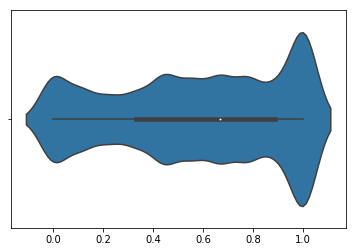

In [95]:
# Ratings distribution for a sample of 10000 users
sns.violinplot([pandas_df.label])

Without considering any unbalance in the dataset, let's split it into a cross-validation subset and a test subset (for overfitting evaluation):

In [25]:
# Split into train and test subsets
(cv_data, test) = df.randomSplit([0.8, 0.2])

##### Model selection
Model selection process will be performed through cross-validation analysis with automatic hyperparameter tunning. This tunning is done by defining a grid of model's hyperparameters combinations and running a grid search over the combinations to compare the performance of the resulting models and finally get the optimal one. The ALS hyperparameters are:

- rank = the number of latent factors in the model (4, 8 and 12 as selected values)
- maxIter = the maximum number of iterations (default value)
- regParam = the regularization parameter (0.1, 0.05 and 0.01 as selected values)

The previous process can be rapidly implemented using Spark CrossValidator function.

In order to measure how good each model hyperparamenter selection is so we can compare it against other tries to finally keep the best ALS model, we have to set a evaluator based on the Root Mean Square Error (RMSE) as it is commonly used as main evaluation metric in regression analysis. RMSE compares the predicted values from the training set with the real values present in the validation set. By adding the absolute error od the differences and taking the average of those values we get a measure of the model's error. The  smaller  the  error, the better the forecasting ability of that model according to the RMSE criterion.

However, text books and research papers in the field (e.g. F.O. Isinkayea, Y.O. Folajimib, B.A. Ojokohc, 2015) recommend using RankingMetrics-like evaluations to compute metrics such as average precision at K or MAP, etc. More information can be obtained here: https://ac.els-cdn.com/S1110866515000341/1-s2.0-S1110866515000341-main.pdf?_tid=c6864687-4a8f-45cb-ad27-d8c0b6ff58cc&acdnat=1526400969_04e6762edfb3fcebebc42652fcf9636f

In [ ]:
# Set model
als = ALS(userCol="user_id", itemCol="profile_id", ratingCol="label", coldStartStrategy="drop", seed=0, nonnegative=True)

# Set considered parameter grid
paramGrid = ParamGridBuilder().addGrid(als.regParam, [0.1, 0.05, 0.01]).addGrid(als.rank, [4, 8, 12]).build()

# Set evaluator
modelEvaluator = RegressionEvaluator(metricName="rmse")

# Set cross validator instance
crossval = CrossValidator(estimator=als,
                          estimatorParamMaps=paramGrid,
                          evaluator=modelEvaluator,
                          numFolds=10)

# Perform cross-validation
cvModel = crossval.fit(cv_data)

In [31]:
# Select best model and get its parameters
best_als_model = cvModel.bestModel
print("Best number of latent factors (rank parameter): " + str(best_als_model.rank))
print("Best value of regularization factor: " + str(best_als_model._java_obj.parent().getRegParam()))
print("Max Iterations: " + str(best_als_model._java_obj.parent().getMaxIter()))

Best number of latent factors (rank parameter): 8
Best value of regularization factor: 0.01
Max Iterations: 10


In [33]:
# Make predictions on a random test subset obtained through randomSplit()
print("Predictions based on a random test subset:")
predictions = best_als_model.transform(test)
predictions.show(5)

# Evaluate model's performance on test (evaluate overfitting)
def overfitting_evaluation(predictions):
    # Model evaluation in test - ratings regression evaluation
    print("Model evaluation on test data:")
    predictions = predictions.na.drop()
    # RMSE
    rmse_evaluator = RegressionEvaluator(metricName="rmse", labelCol="label", predictionCol="prediction")
    rmse = rmse_evaluator.evaluate(predictions)
    print("Root-mean-square error (RMSE) = " + str(rmse))
    # MSE
    mse_evaluator = RegressionEvaluator(metricName="mse", labelCol="label", predictionCol="prediction")
    mse = mse_evaluator.evaluate(predictions)
    print("Mean-square error (MSE) = " + str(mse))
    # R2
    r2_evaluator = RegressionEvaluator(metricName="r2", labelCol="label", predictionCol="prediction")
    r2 = r2_evaluator.evaluate(predictions)
    print("r² metric = " + str(r2))
    # MAE
    mae_evaluator = RegressionEvaluator(metricName="mae", labelCol="label", predictionCol="prediction")
    mae = mae_evaluator.evaluate(predictions)
    print("Mean Absolute Error (MAE) = " + str(mae))

    return [rmse, mse, r2, mae]

random_test_eval = overfitting_evaluation(predictions)

Predictions based on a random test subset:
+-------+----------+------------------+----------+
|user_id|profile_id|             label|prediction|
+-------+----------+------------------+----------+
|  83775|       496|0.6666666666666666| 0.5487299|
|  83524|       496|               1.0| 0.9750136|
|  28584|       833|               1.0| 0.7296401|
| 114979|      1238|0.6666666666666666| 0.5668328|
|  96625|      1238|0.6666666666666666|0.43366265|
+-------+----------+------------------+----------+
only showing top 5 rows

Model evaluation on test data:
Root-mean-square error (RMSE) = 0.204187073287
Mean-square error (MSE) = 0.0416923608976
r² metric = 0.650955563635
Mean Absolute Error (MAE) = 0.140817836752


In order to get a more accurate evaluation of the model's overfitting or real performance score, once the ALS model with the best hyperparameters' tunning has been selected (model selection process above, done by cross-validation with grid search), a "cross-testing" process will be performed by randomly splitting the dataset in test and train subsets through multiple K-folds and finally averaging the evaluation scores results from all of them. This process will bring us a more precise evaluation of our recommendation engine as rating predictor based on new incoming and unknown data:

In [37]:
def kfold_test_eval(df, Kfolds=5):
    rmse_evaluations = []
    mse_evaluations = []
    r2_evaluations = []
    mae_evaluations = []
    
    for k in range(0, Kfolds):  
        (train, test) = df.randomSplit([0.8, 0.2])
        tunned_als = als = ALS(userCol="user_id", itemCol="profile_id", ratingCol="label", coldStartStrategy="drop", maxIter=10, regParam=0.01, rank=8)
        model = tunned_als.fit(train)
        predictions = model.transform(test)
        print("Kfold: " + str(k + 1))
        k_test_eval = overfitting_evaluation(predictions)
        rmse_evaluations.append(k_test_eval[0])
        mse_evaluations.append(k_test_eval[1])
        r2_evaluations.append(k_test_eval[2])
        mae_evaluations.append(k_test_eval[3])
        
    average_rmse = sum(rmse_evaluations)/float(len(rmse_evaluations))
    average_mse = sum(mse_evaluations)/float(len(mse_evaluations))
    average_r2 = sum(r2_evaluations)/float(len(r2_evaluations))
    average_mae = sum(mae_evaluations)/float(len(mae_evaluations))
    
    return [average_rmse, average_mse, average_r2, average_mae]

[average_rmse, average_mse, average_r2, average_mae] = kfold_test_eval(df)

Kfold: 1
Model evaluation on test data:
Root-mean-square error (RMSE) = 0.20391433442
Mean-square error (MSE) = 0.0415810557818
r² metric = 0.652298908326
Mean Absolute Error (MAE) = 0.140649161842
Kfold: 2
Model evaluation on test data:
Root-mean-square error (RMSE) = 0.203889882912
Mean-square error (MSE) = 0.0415710843538
r² metric = 0.652080043098
Mean Absolute Error (MAE) = 0.140665389168
Kfold: 3
Model evaluation on test data:
Root-mean-square error (RMSE) = 0.203946162256
Mean-square error (MSE) = 0.0415940370991
r² metric = 0.651956730196
Mean Absolute Error (MAE) = 0.14069721078
Kfold: 4
Model evaluation on test data:
Root-mean-square error (RMSE) = 0.203787149489
Mean-square error (MSE) = 0.0415292022968
r² metric = 0.652295712351
Mean Absolute Error (MAE) = 0.140558859288
Kfold: 5
Model evaluation on test data:
Root-mean-square error (RMSE) = 0.203965428419
Mean-square error (MSE) = 0.04160189599
r² metric = 0.651672187006
Mean Absolute Error (MAE) = 0.140626773966


In [39]:
# Average performance score of the selected model:
print("Average Root-mean-square error (RMSE) = " + str(average_rmse))
print("Average Mean-square error (MSE) = " + str(average_mse))
print("Average r² metric = " + str(average_r2))
print("Average Mean Absolute Error (MAE) " + str(average_mae))

Average Root-mean-square error (RMSE) = 0.203900591499
Average Mean-square error (MSE) = 0.0415754551043
Average r² metric = 0.652060716195
Average Mean Absolute Error (MAE) 0.140639479009


Finally let's obtain some recommendations from the built model for different cases:

In [96]:
# Generate top 10 profiles recommendations for each user
userRecs = best_als_model.recommendForAllUsers(10)
userRecs.show(1, truncate=False)

+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                             |
+-------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|148    |[[159513, 2.6826572], [135056, 2.2142038], [80297, 2.181056], [199770, 2.0491154], [67442, 1.9784403], [22972, 1.9325198], [128646, 1.9314922], [56050, 1.9247315], [96515, 1.8710849], [179283, 1.8512474]]|
+-------+-----------------------------------------------------------------------------------------------------------------------------------

In [97]:
# Generate top 10 user recommendations for each profile
profileRecs = best_als_model.recommendForAllItems(10)
profileRecs.show(1, truncate=False)

+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|profile_id|recommendations                                                                                                                                                                                         |
+----------+--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|496       |[[10115, 1.7967153], [36243, 1.6167616], [123794, 1.5479522], [79671, 1.5467885], [38123, 1.5259393], [65649, 1.5140268], [66232, 1.4930097], [20044, 1.4844044], [26508, 1.483938], [61468, 1.4789674]]|
+----------+------------------------------------------------------------------------------------------------------------------------------------

In [43]:
# Generate top 10 profile recommendations for a set of 10 users
users = test.select(als.getUserCol()).distinct().limit(10)
userSubsetRecs = best_als_model.recommendForUserSubset(users, 10)
userSubsetRecs.show(truncate=False)

+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|user_id|recommendations                                                                                                                                                                                                |
+-------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|1580   |[[73450, 2.1160717], [196118, 1.9395694], [44768, 1.861454], [46427, 1.8534217], [62877, 1.800837], [121938, 1.7637302], [35786, 1.7616118], [218717, 1.7597885], [185904, 1.7546182], [114965, 1.7449896]]    |
|471    |[[56050, 1.8613569], [169405, 1.6265004], [141912, 1.6238357], [199020, 1.5705091], [153801, 1.5702825], [37519, 1.5582

In [44]:
# Generate top 10 user recommendations for a set of 10 profiles
profiles = test.select(als.getItemCol()).distinct().limit(10)
profileSubSetRecs = best_als_model.recommendForItemSubset(profiles, 10)
profileSubSetRecs.show(truncate=False)

+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|profile_id|recommendations                                                                                                                                                                                                  |
+----------+-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|128131    |[[88607, 1.2465376], [40188, 1.2444562], [69236, 1.2178707], [82086, 1.2172562], [42639, 1.2150319], [121684, 1.2045647], [91642, 1.1989311], [10115, 1.1987841], [29150, 1.1812139], [66232, 1.1797979]]        |
|87462     |[[26871, 1.207882], [81073, 1.2014818], [83148, 1.1523317], [29112, 1.136605], [91642, 1.1039877

In [86]:
# Generate recommendations for a specific user
def profiles4userID(als_model, uid, limit=10):
    data = df.select("profile_id").distinct().withColumn("user_id", F.lit(uid))
    rated_profiles = df.filter(df.user_id == uid).select("profile_id", "user_id")
    predictions = als_model.transform(data.subtract(rated_profiles)).dropna().orderBy("prediction", ascending=False).limit(limit).select("profile_id", "prediction")
    predictions.join(gender_df.filter(gender_df.gender != "U"), predictions.profile_id == gender_df.profile_id).select(predictions.profile_id, gender_df.gender, predictions.prediction).show(1)

gender_df.filter(gender_df.profile_id == "1000").show()
print("Recommended contact for user 1000:")
profiles4userID(best_als_model, 1000)

+----------+------+
|profile_id|gender|
+----------+------+
|      1000|     M|
+----------+------+

Recommended contact for user 1000:
+----------+------+----------+
|profile_id|gender|prediction|
+----------+------+----------+
|     13308|     F| 1.4781343|
+----------+------+----------+
only showing top 1 row



Some observations about PySpark ALS implementation and evaluation results on these spark issues links:

https://issues.apache.org/jira/browse/SPARK-14489

https://issues.apache.org/jira/browse/SPARK-19345

###### References
https://datascience.ibm.com/exchange/public/entry/view/99b857815e69353c04d95daefb3b91fa

https://endymecy.gitbooks.io/spark-ml-source-analysis/content/%E6%8E%A8%E8%8D%90/papers/Large-scale%20Parallel%20Collaborative%20Filtering%20the%20Netflix%20Prize.pdf

http://cs229.stanford.edu/proj2014/Christopher%20Aberger,%20Recommender.pdf

http://www.ijircce.com/upload/2017/april/262_Book.pdf

https://helda.helsinki.fi/bitstream/handle/10138/156542/andrewsthesis.pdf?sequence=2